In [2]:
from BMI_HBVmountain_Python import *

## Load forcing data

In [3]:
# obs = pd.read_csv('Data/BigCreek/forcing_bigrockcreek.csv', index_col=[0], parse_dates=True)
# pd.to_datetime(obs.index);
# obs = obs.reset_index(level=0)
# for i in range(len(obs)):
#     obs['time'][i] = obs['time'][i].date()
# obs.set_index('time', inplace=True)
forcing = pd.read_csv('Data/Youghiogheny/Discharge_Youghiogheny.csv', index_col=[0], parse_dates=True)
forcing = forcing /(347.1 * 1e6) * 1000 *86400
# forcing = nc.Dataset('Data/BigCreek/HBVmountain_ERA5_BigRockCreek_1986_2015.nc')
# generate_forcing_from_NETCDF(forcing)

## Setting up the model

In [4]:
model = BMI_HBVmountain(forcing_netcdf=forcing)

In [5]:
config_file = model.setup()

In [6]:
model.initialize(config_file)

### Parameters => implement in model.setup()

In [6]:
# bare_parameters, forest_parameters, grass_parameters, rip_parameters,  slow_parameters, parameters_array =  Main.parameter_selection() #Generate random parameterset
# model.set_value('bare_parameters', bare_parameters)
# model.set_value('forest_parameters', forest_parameters)
# model.set_value('grass_parameters', grass_parameters)
# model.set_value('rip_parameters', rip_parameters)
# model.set_value('slow_parameters', slow_parameters)

### Forcings

In [7]:
model.set_value('Temperature', (forcing['temp_era5'].values.reshape(len(forcing),1)))
model.set_value('Precipitation', (forcing['prec_era5'].values.reshape(len(forcing),1)))

model.set_value('Date', list(forcing.index.values))
model.set_value('Current_Date', forcing.index.values[0])

### Initial settings => implement in model.setup()

In [22]:
# model.set_value('Elevation', Main.Elevations(500, 500, 2500, 1500, 1500)) # 4 Elevation bands

# model.set_value('Glacier', [0.0, 0.0, 0.0, 0.6]) # 60% of the area glacier at highest elevation band
# model.set_value('Sunhours', [8.87, 10.30, 11.88, 13.65, 15.13, 15.97, 15.58, 14.25, 12.62, 11.87, 9.28, 8.45]) #Seattle
# model.set_value('bare_input', Main.HRU_Input([0.0,0.0,0.3,0.7], 0.32, [0.0, 0.0, 0.0, 0.6], [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
# model.set_value('forest_input', Main.HRU_Input([0.0,0.7,0.3,0.0], 0.45,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
# model.set_value('grass_input', Main.HRU_Input([0.7,0.3,0.0,0.0], 0.21,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
# model.set_value('rip_input', Main.HRU_Input([1.0,0.0,0.0,0.0], 0.02,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
# model.set_value('Total_Elevationbands', 4)
# model.set_value('Elevation_Percentage', [0.15,0.26,0.36,0.23])
# model.set_value('bare_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
# model.set_value('forest_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
# model.set_value('grass_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
# model.set_value('rip_storage', Main.Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))

## Running the model

In [7]:
Discharge = []
timestamp = []
while (model.get_value_ptr('Current_Date') < (model.get_value_ptr('Date')[-1])):  
    model.update()
    timestamp.append(model.get_value_ptr('Current_Date'))
    Discharge.append(model.get_value_ptr('Discharge'))

## Analysis

In [13]:
simulated_discharge_df = pd.DataFrame(
    {'simulation': Discharge},
    index=pd.to_datetime(timestamp)
)
combined_discharge = pd.merge(simulated_discharge_df, obs['streamflow'], left_index=True, right_index=True)
combined_discharge

,simulation,streamflow
1986-01-02,0.000000,0.971722
1986-01-03,0.000000,0.953927
1986-01-04,0.000000,0.944712
1986-01-05,0.000000,0.944712
1986-01-06,0.000022,0.962825
...,...,...
2005-12-27,0.005196,6.451560
2005-12-28,0.004961,5.173832
2005-12-29,0.004737,4.535126
2005-12-30,0.004523,4.067060


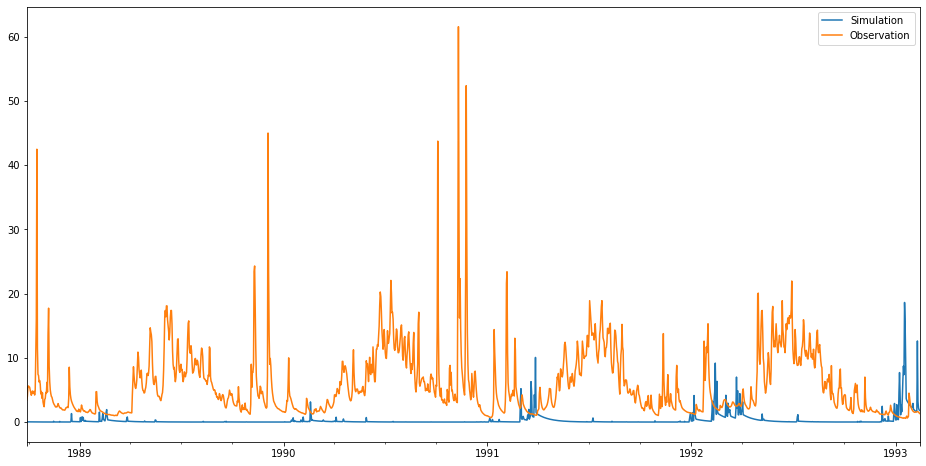

In [14]:
plt.figure(figsize=[16,8])
combined_discharge.simulation.iloc[1000:2600].plot(label='Simulation')
combined_discharge.streamflow.iloc[1000:2600].plot(label='Observation')
plt.legend();

## Clean up

In [42]:
model.finalize()

Text(0, 0.5, 'mm day-1')

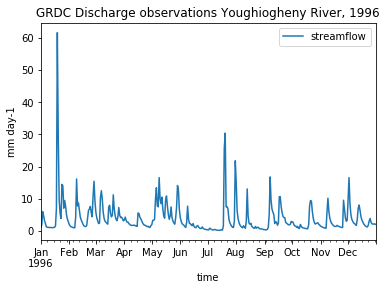

In [4]:
forcing.loc[forcing.index.year==1996].plot()
plt.title('GRDC Discharge observations Youghiogheny River, 1996')
plt.ylabel('mm day-1')